In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- 1. Key Parameters ---
VOCAB_SIZE = 5000
MAX_SEQ_LEN = 100
BATCH_SIZE = 64
NUM_EPOCHS = 10
EMBED_DIM = 64
HIDDEN_DIM = 128
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. Data Preparation Definitions ---
# (Note: Data is loaded in the next cell)

tokenizer = get_tokenizer('basic_english')

def yield_tokens_from_df(df):
    for text in df['review']:
        yield tokenizer(str(text))

def text_pipeline(text, vocab):
    tokens = tokenizer(str(text))
    return [vocab[token] for token in tokens]

class IMDB_CSV_Dataset(Dataset):
    def __init__(self, df, vocab):
        self.reviews = df['review'].tolist()
        self.labels = [1.0 if s == 'positive' else 0.0 for s in df['sentiment']]
        
        # Process all texts during initialization
        self.processed_texts = []
        for text in self.reviews:
            self.processed_texts.append(text_pipeline(text, vocab))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        processed_text = self.processed_texts[idx]
        return label, processed_text

def collate_batch(batch, pad_idx):
    label_list, text_list = [], []
    for (label, processed_text) in batch:
        label_list.append(label)
        
        # Create a copy to avoid modifying the original dataset
        processed_text_tensor = torch.tensor(processed_text, dtype=torch.int64)
        
        # Truncate if longer than MAX_SEQ_LEN
        if len(processed_text_tensor) > MAX_SEQ_LEN:
            processed_text_tensor = processed_text_tensor[:MAX_SEQ_LEN]
        # Pad if shorter
        elif len(processed_text_tensor) < MAX_SEQ_LEN:
            padding = torch.tensor([pad_idx] * (MAX_SEQ_LEN - len(processed_text_tensor)), dtype=torch.int64)
            processed_text_tensor = torch.cat((processed_text_tensor, padding))
        
        text_list.append(processed_text_tensor)

    # Stack all tensors at once
    labels = torch.tensor(label_list, dtype=torch.float32).unsqueeze(-1)
    texts = torch.stack(text_list)
    
    return texts.to(device), labels.to(device)

# --- 3. Model Definition ---
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx, model_type='LSTM', n_layers=2, dropout=0.3):
        super().__init__()
        self.model_type = model_type
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        
        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=n_layers, 
                              batch_first=True, dropout=dropout)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers,
                              batch_first=True, dropout=dropout)
        else: # Default to LSTM
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                               batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        if self.model_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1, :, :])
        prediction = self.fc(hidden)
        return prediction

# --- 4. Training and Evaluation Functions ---
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for i, (texts, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        preds_binary = torch.round(torch.sigmoid(predictions))
        correct = (preds_binary == labels).float()
        acc = correct.sum() / len(correct)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc.item()
    return total_loss / len(dataloader), total_acc / len(dataloader)

def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for texts, labels in dataloader:
            predictions = model(texts)
            loss = criterion(predictions, labels)
            preds_binary = torch.round(torch.sigmoid(predictions))
            correct = (preds_binary == labels).float()
            acc = correct.sum() / len(correct)
            total_loss += loss.item()
            total_acc += acc.item()
    return total_loss / len(dataloader), total_acc / len(dataloader)

def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in dataloader:
            predictions = model(texts)
            preds_binary = torch.round(torch.sigmoid(predictions))
            
            all_preds.append(preds_binary.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    return all_preds, all_labels

print("Cell 1 Complete: All parameters, classes, and functions are defined.")

Using device: cuda
Cell 1 Complete: All parameters, classes, and functions are defined.


In [3]:
# --- 2. Data Loading ---
CSV_PATH = "IMDB dataset.csv"
print("Loading data and building vocabulary from single CSV...")

try:
    df_full = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{CSV_PATH}'.")
    # exit() # Use raise instead of exit() in a notebook
    raise
except KeyError:
    print("Error: CSV file must have columns named 'review' and 'sentiment'.")
    raise

df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42)
print(f"Data split: {len(df_train)} training samples, {len(df_test)} testing samples.")

# Build vocabulary
vocab = build_vocab_from_iterator(
    yield_tokens_from_df(df_train),
    specials=['<unk>', '<pad>'],
    max_tokens=VOCAB_SIZE
)
vocab.set_default_index(vocab['<unk>'])
PAD_IDX = vocab['<pad>']
print(f"Vocabulary built. Size: {len(vocab)}")

# Create Datasets
train_dataset = IMDB_CSV_Dataset(df_train, vocab)
test_dataset = IMDB_CSV_Dataset(df_test, vocab)

# Create DataLoaders
# Use functools.partial to pass the pad_idx to the collate_fn
from functools import partial

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=partial(collate_batch, pad_idx=PAD_IDX))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=partial(collate_batch, pad_idx=PAD_IDX))

print("DataLoaders created successfully.")


# --- 5. Main Study Execution ---
model_types_to_study = ['RNN', 'GRU', 'LSTM']
results = {}
full_history = {} 
trained_models = {} 

print("\n--- Starting Comparative Study ---")

for model_type in model_types_to_study:
    print(f"\n--- Training Model: {model_type} ---")
    
    model = SentimentModel(
        vocab_size=len(vocab), # Use the actual vocab size
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=1,
        pad_idx=PAD_IDX, # Pass pad_idx to model
        model_type=model_type
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    
    best_test_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion)
        test_loss, test_acc = evaluate_epoch(model, test_dataloader, criterion)
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tTest. Loss: {test_loss:.3f} | Test. Acc: {test_acc*100:.2f}%')
    
    results[model_type] = best_test_acc * 100
    full_history[model_type] = history
    trained_models[model_type] = model # Save the trained model

# --- Final Results in one line ---
print("\n--- Study Complete ---")
results_line = " | ".join([f"{model}: {acc:.2f}%" for model, acc in results.items()])
print(f"Final Best Test Accuracies (over 10 epochs): {results_line}")
print("\nCell 2 Complete: Models are trained and results are stored in variables.")

Loading data and building vocabulary from single CSV...
Data split: 40000 training samples, 10000 testing samples.
Vocabulary built. Size: 5000
DataLoaders created successfully.

--- Starting Comparative Study ---

--- Training Model: RNN ---
Epoch: 01 | Time: 0m 2s
	Train Loss: 0.696 | Train Acc: 50.87%
	Test. Loss: 0.697 | Test. Acc: 49.00%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.695 | Train Acc: 50.46%
	Test. Loss: 0.693 | Test. Acc: 50.75%
Epoch: 03 | Time: 0m 2s
	Train Loss: 0.694 | Train Acc: 51.17%
	Test. Loss: 0.693 | Test. Acc: 51.32%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.693 | Train Acc: 51.50%
	Test. Loss: 0.694 | Test. Acc: 51.06%
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.693 | Train Acc: 52.23%
	Test. Loss: 0.694 | Test. Acc: 50.28%
Epoch: 06 | Time: 0m 2s
	Train Loss: 0.691 | Train Acc: 53.07%
	Test. Loss: 0.694 | Test. Acc: 51.98%
Epoch: 07 | Time: 0m 2s
	Train Loss: 0.693 | Train Acc: 52.24%
	Test. Loss: 0.694 | Test. Acc: 48.39%
Epoch: 08 | Time: 0m 2s
	Train Loss: 0.695 


Generating final plots...


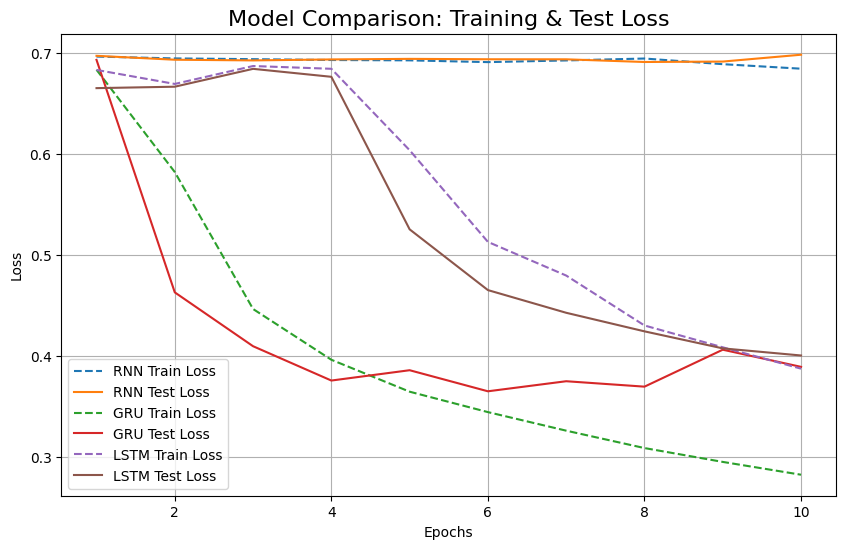

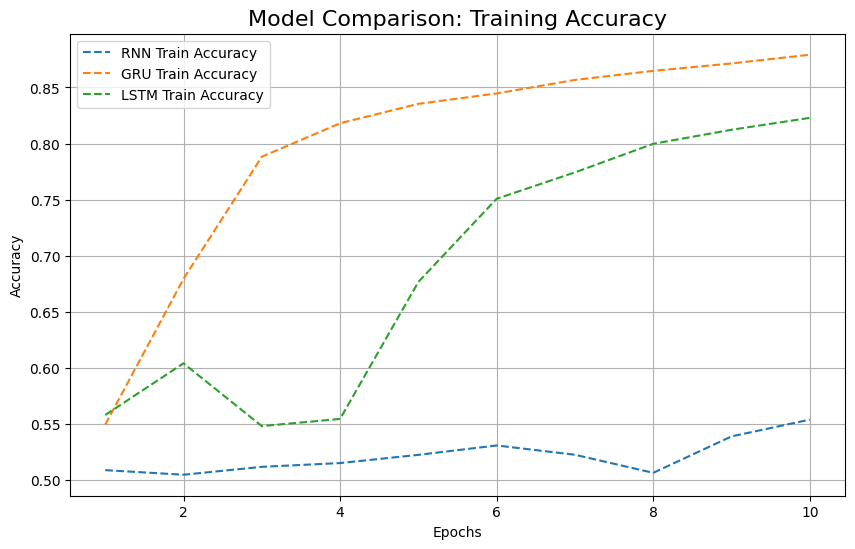


Generating Confusion Matrices...


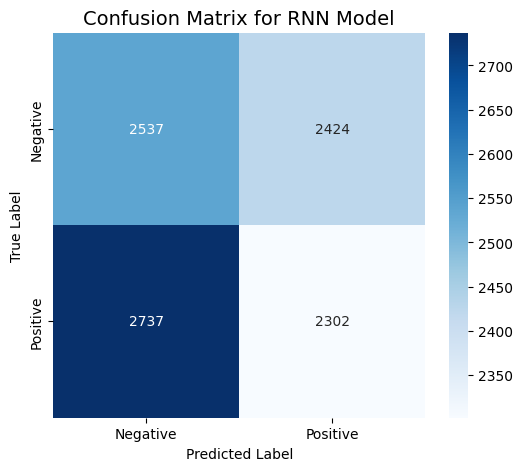

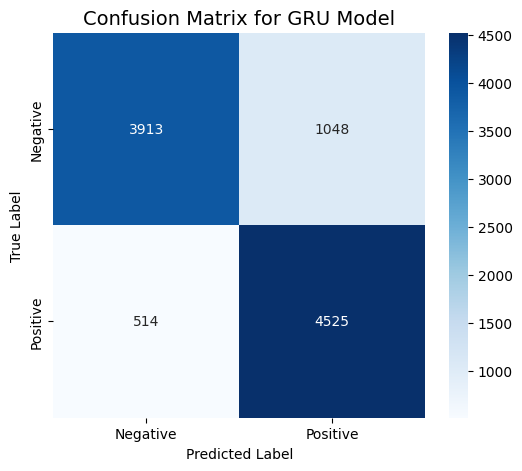

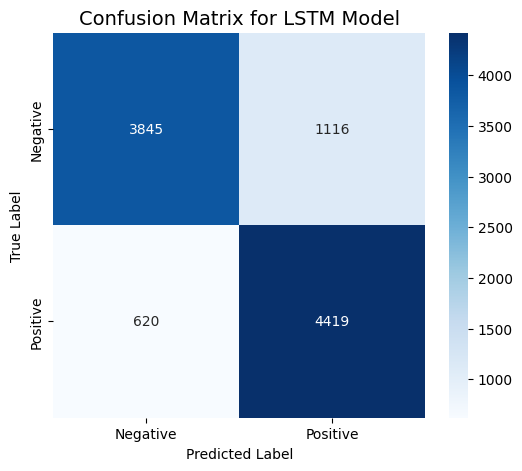


Cell 3 Complete: Analysis finished.


In [4]:
# --- 6. Final Comparative Plots ---
print("\nGenerating final plots...")

# Check if variables exist before plotting
if 'full_history' not in locals():
    print("Error: 'full_history' not found. Please run Cell 2 to train models first.")
else:
    epochs_range = range(1, NUM_EPOCHS + 1)

    # --- PLOT 1: LOSS (Train & Test) ---
    plt.figure(figsize=(10, 6))
    for model_type, history in full_history.items():
        plt.plot(epochs_range, history['train_loss'], label=f'{model_type} Train Loss', linestyle='--')
        plt.plot(epochs_range, history['test_loss'], label=f'{model_type} Test Loss')

    plt.title('Model Comparison: Training & Test Loss', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- PLOT 2: ACCURACY (Train ONLY) ---
    plt.figure(figsize=(10, 6))
    for model_type, history in full_history.items():
        plt.plot(epochs_range, history['train_acc'], label=f'{model_type} Train Accuracy', linestyle='--')

    plt.title('Model Comparison: Training Accuracy', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 7. Confusion Matrices ---
print("\nGenerating Confusion Matrices...")

if 'trained_models' not in locals():
    print("Error: 'trained_models' not found. Please run Cell 2 to train models first.")
else:
    for model_type, model in trained_models.items():
        # Get predictions and true labels
        y_pred, y_true = get_predictions_and_labels(model, test_dataloader)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot heatmap
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Negative', 'Positive'], 
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix for {model_type} Model', fontsize=14)
        plt.show()

print("\nCell 3 Complete: Analysis finished.")

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- 1. Key Parameters ---
VOCAB_SIZE = 5000
MAX_SEQ_LEN = 100
BATCH_SIZE = 64
NUM_EPOCHS = 10
EMBED_DIM = 64
HIDDEN_DIM = 128
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. Data Preparation Definitions ---
tokenizer = get_tokenizer('basic_english')

def yield_tokens_from_df(df):
    for text in df['review']:
        yield tokenizer(str(text))

def text_pipeline(text, vocab):
    tokens = tokenizer(str(text))
    return [vocab[token] for token in tokens]

class IMDB_CSV_Dataset(Dataset):
    def __init__(self, df, vocab):
        self.reviews = df['review'].tolist()
        self.labels = [1.0 if s == 'positive' else 0.0 for s in df['sentiment']]
        
        self.processed_texts = []
        for text in self.reviews:
            self.processed_texts.append(text_pipeline(text, vocab))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        processed_text = self.processed_texts[idx]
        return label, processed_text

def collate_batch(batch, pad_idx):
    label_list, text_list = [], []
    for (label, processed_text) in batch:
        label_list.append(label)
        processed_text_tensor = torch.tensor(processed_text, dtype=torch.int64)
        
        if len(processed_text_tensor) > MAX_SEQ_LEN:
            processed_text_tensor = processed_text_tensor[:MAX_SEQ_LEN]
        elif len(processed_text_tensor) < MAX_SEQ_LEN:
            padding = torch.tensor([pad_idx] * (MAX_SEQ_LEN - len(processed_text_tensor)), dtype=torch.int64)
            processed_text_tensor = torch.cat((processed_text_tensor, padding))
        
        text_list.append(processed_text_tensor)

    labels = torch.tensor(label_list, dtype=torch.float32).unsqueeze(-1)
    texts = torch.stack(text_list)
    
    return texts.to(device), labels.to(device)

# --- 3. Model Definitions (UPDATED) ---

# ---vvv--- Model 1: Baseline (No Dropout) ---vvv---
class SentimentModel_NoDropout(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx, model_type='LSTM', n_layers=2):
        super().__init__()
        self.model_type = model_type
        # Note: embedding layer's dropout is removed
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        
        # Note: RNN's internal dropout is removed (dropout=0)
        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=n_layers, 
                              batch_first=True, dropout=0)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers,
                              batch_first=True, dropout=0)
        else: # Default to LSTM
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                               batch_first=True, dropout=0)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        # Note: Final dropout layer is removed

    def forward(self, text):
        embedded = self.embedding(text) # Dropout removed
        
        if self.model_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
            
        hidden = hidden[-1, :, :] # Dropout removed
        prediction = self.fc(hidden)
        return prediction

# ---vvv--- Model 2: Extra Layer (No Dropout) ---vvv---
class ExtraLayerModel_NoDropout(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx, model_type='LSTM', n_layers=2):
        super().__init__()
        self.model_type = model_type
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        
        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=n_layers, 
                              batch_first=True, dropout=0)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers,
                              batch_first=True, dropout=0)
        else: # Default to LSTM
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                               batch_first=True, dropout=0)
        
        extra_layer_dim = hidden_dim // 2
        self.extra_layer = nn.Linear(hidden_dim, extra_layer_dim)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(extra_layer_dim, output_dim) 
        # Note: No dropout layers anywhere

    def forward(self, text):
        embedded = self.embedding(text) # Dropout removed
        
        if self.model_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
            
        hidden = hidden[-1, :, :] # Dropout removed
        
        out_extra = self.extra_layer(hidden)
        out_relu = self.relu(out_extra)
        prediction = self.fc(out_relu)
        
        return prediction

# --- 4. Training and Evaluation Functions ---
# (These are unchanged)
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for i, (texts, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        preds_binary = torch.round(torch.sigmoid(predictions))
        correct = (preds_binary == labels).float()
        acc = correct.sum() / len(correct)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc.item()
    return total_loss / len(dataloader), total_acc / len(dataloader)

def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for texts, labels in dataloader:
            predictions = model(texts)
            loss = criterion(predictions, labels)
            preds_binary = torch.round(torch.sigmoid(predictions))
            correct = (preds_binary == labels).float()
            acc = correct.sum() / len(correct)
            total_loss += loss.item()
            total_acc += acc.item()
    return total_loss / len(dataloader), total_acc / len(dataloader)

def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in dataloader:
            predictions = model(texts)
            preds_binary = torch.round(torch.sigmoid(predictions))
            
            all_preds.append(preds_binary.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    return all_preds, all_labels

print("Cell 1 Complete: All parameters and NEW model classes (No Dropout) are defined.")

Using device: cuda
Cell 1 Complete: All parameters and NEW model classes (No Dropout) are defined.


In [7]:
# --- 2. Data Loading ---
CSV_PATH = "IMDB dataset.csv"
print("Loading data and building vocabulary from single CSV...")

try:
    df_full = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{CSV_PATH}'.")
    raise
except KeyError:
    print("Error: CSV file must have columns named 'review' and 'sentiment'.")
    raise

df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42)
print(f"Data split: {len(df_train)} training samples, {len(df_test)} testing samples.")

# Build vocabulary
vocab = build_vocab_from_iterator(
    yield_tokens_from_df(df_train),
    specials=['<unk>', '<pad>'],
    max_tokens=VOCAB_SIZE
)
vocab.set_default_index(vocab['<unk>'])
PAD_IDX = vocab['<pad>']
print(f"Vocabulary built. Size: {len(vocab)}")

# Create Datasets
train_dataset = IMDB_CSV_Dataset(df_train, vocab)
test_dataset = IMDB_CSV_Dataset(df_test, vocab)

# Create DataLoaders
from functools import partial

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=partial(collate_batch, pad_idx=PAD_IDX))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=partial(collate_batch, pad_idx=PAD_IDX))

print("DataLoaders created successfully.")


# --- 5. Main Study Execution (UPDATED FOR 6 MODELS) ---

# ---vvv--- NEW: Define the 2 experiments ---vvv---
experiments = [
    ("Baseline_NoDropout", SentimentModel_NoDropout),
    ("ExtraLayer_NoDropout", ExtraLayerModel_NoDropout)
]
rnn_types_to_study = ['RNN', 'GRU', 'LSTM']

# These dicts will store the results for all 6 models
results = {}
full_history = {} 
trained_models = {} 

print("\n--- Starting Full Comparative Study (No Dropout) ---")

# Loop over the 2 model classes
for experiment_name, model_class in experiments:
    
    # Loop over the 3 RNN types
    for rnn_type in rnn_types_to_study:
        
        model_key = f"{experiment_name}_{rnn_type}" # e.g., "Baseline_NoDropout_RNN"
        print(f"\n--- Training Model: {model_key} ---")
        
        model = model_class(
            vocab_size=len(vocab),
            embed_dim=EMBED_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=1,
            pad_idx=PAD_IDX,
            model_type=rnn_type
        ).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.BCEWithLogitsLoss()
        
        best_test_acc = 0
        history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
        
        for epoch in range(NUM_EPOCHS):
            start_time = time.time()
            
            train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion)
            test_loss, test_acc = evaluate_epoch(model, test_dataloader, criterion)
            
            end_time = time.time()
            epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\tTest. Loss: {test_loss:.3f} | Test. Acc: {test_acc*100:.2f}%')
        
        results[model_key] = best_test_acc * 100
        full_history[model_key] = history
        trained_models[model_key] = model # Save the trained model

# --- Final Results in one line ---
print("\n--- Study Complete ---")
print("Final Best Test Accuracies (over 10 epochs):")
for model_key, acc in results.items():
    print(f"\t{model_key}: {acc:.2f}%")
    
print("\nCell 2 Complete: All 6 models are trained and results are stored.")

Loading data and building vocabulary from single CSV...
Data split: 40000 training samples, 10000 testing samples.
Vocabulary built. Size: 5000
DataLoaders created successfully.

--- Starting Full Comparative Study (No Dropout) ---

--- Training Model: Baseline_NoDropout_RNN ---
Epoch: 01 | Time: 0m 3s
	Train Loss: 0.694 | Train Acc: 51.92%
	Test. Loss: 0.696 | Test. Acc: 52.11%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.693 | Train Acc: 51.89%
	Test. Loss: 0.693 | Test. Acc: 51.68%
Epoch: 03 | Time: 0m 2s
	Train Loss: 0.692 | Train Acc: 52.38%
	Test. Loss: 0.690 | Test. Acc: 52.09%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.691 | Train Acc: 52.55%
	Test. Loss: 0.693 | Test. Acc: 52.26%
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.692 | Train Acc: 52.49%
	Test. Loss: 0.692 | Test. Acc: 52.41%
Epoch: 06 | Time: 0m 2s
	Train Loss: 0.691 | Train Acc: 52.93%
	Test. Loss: 0.694 | Test. Acc: 53.64%
Epoch: 07 | Time: 0m 2s
	Train Loss: 0.690 | Train Acc: 53.72%
	Test. Loss: 0.688 | Test. Acc: 53.70%
Epoch:


Generating final plots...


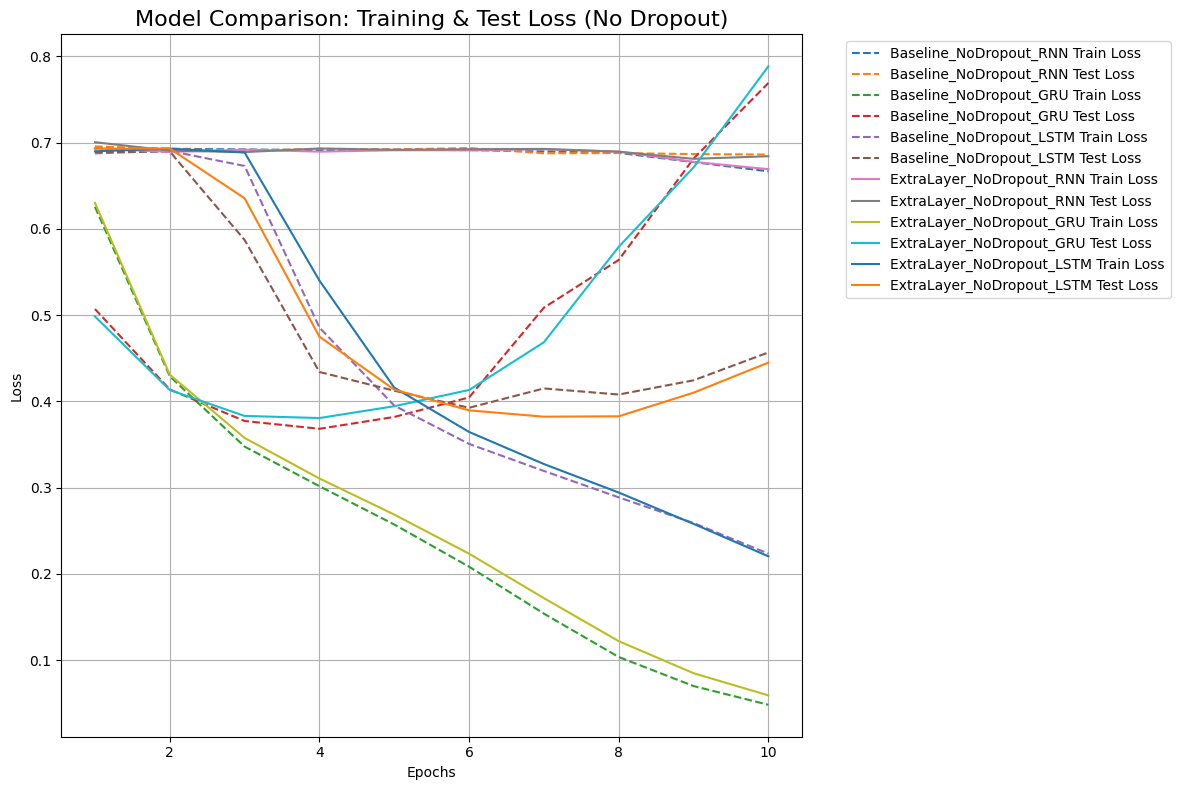

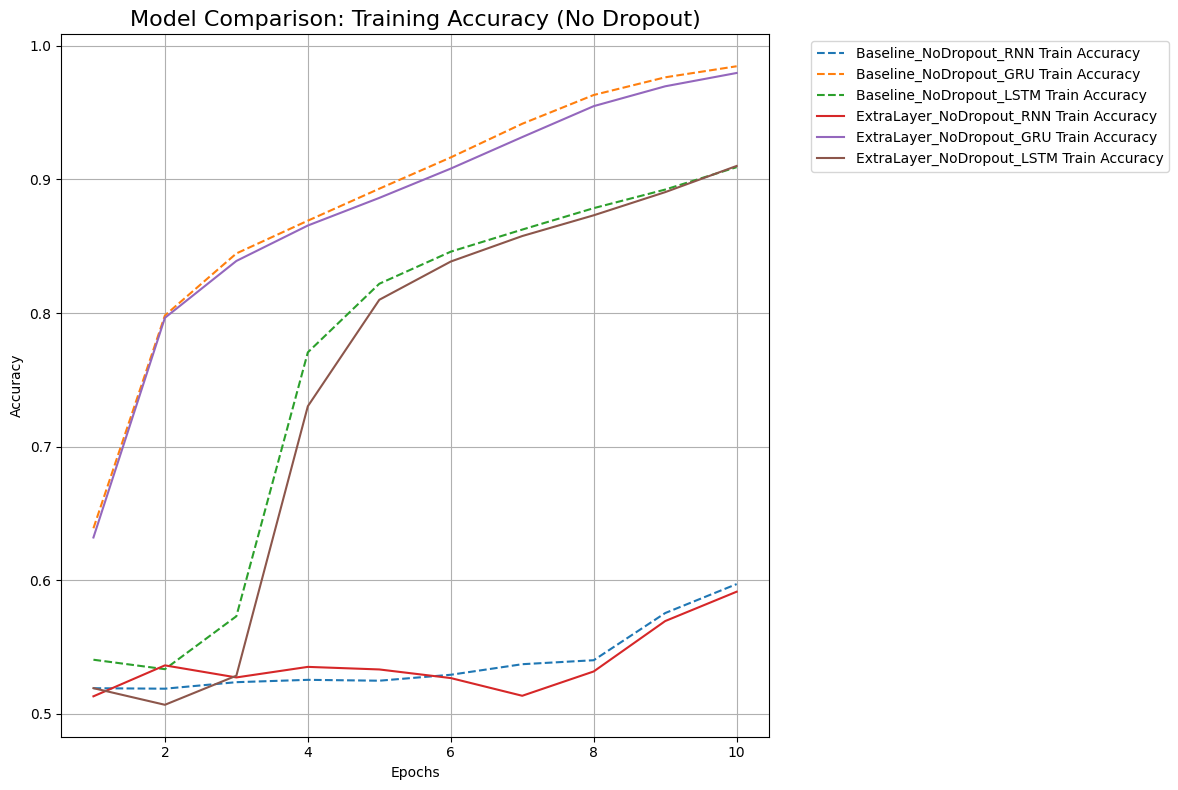


Generating Confusion Matrices...


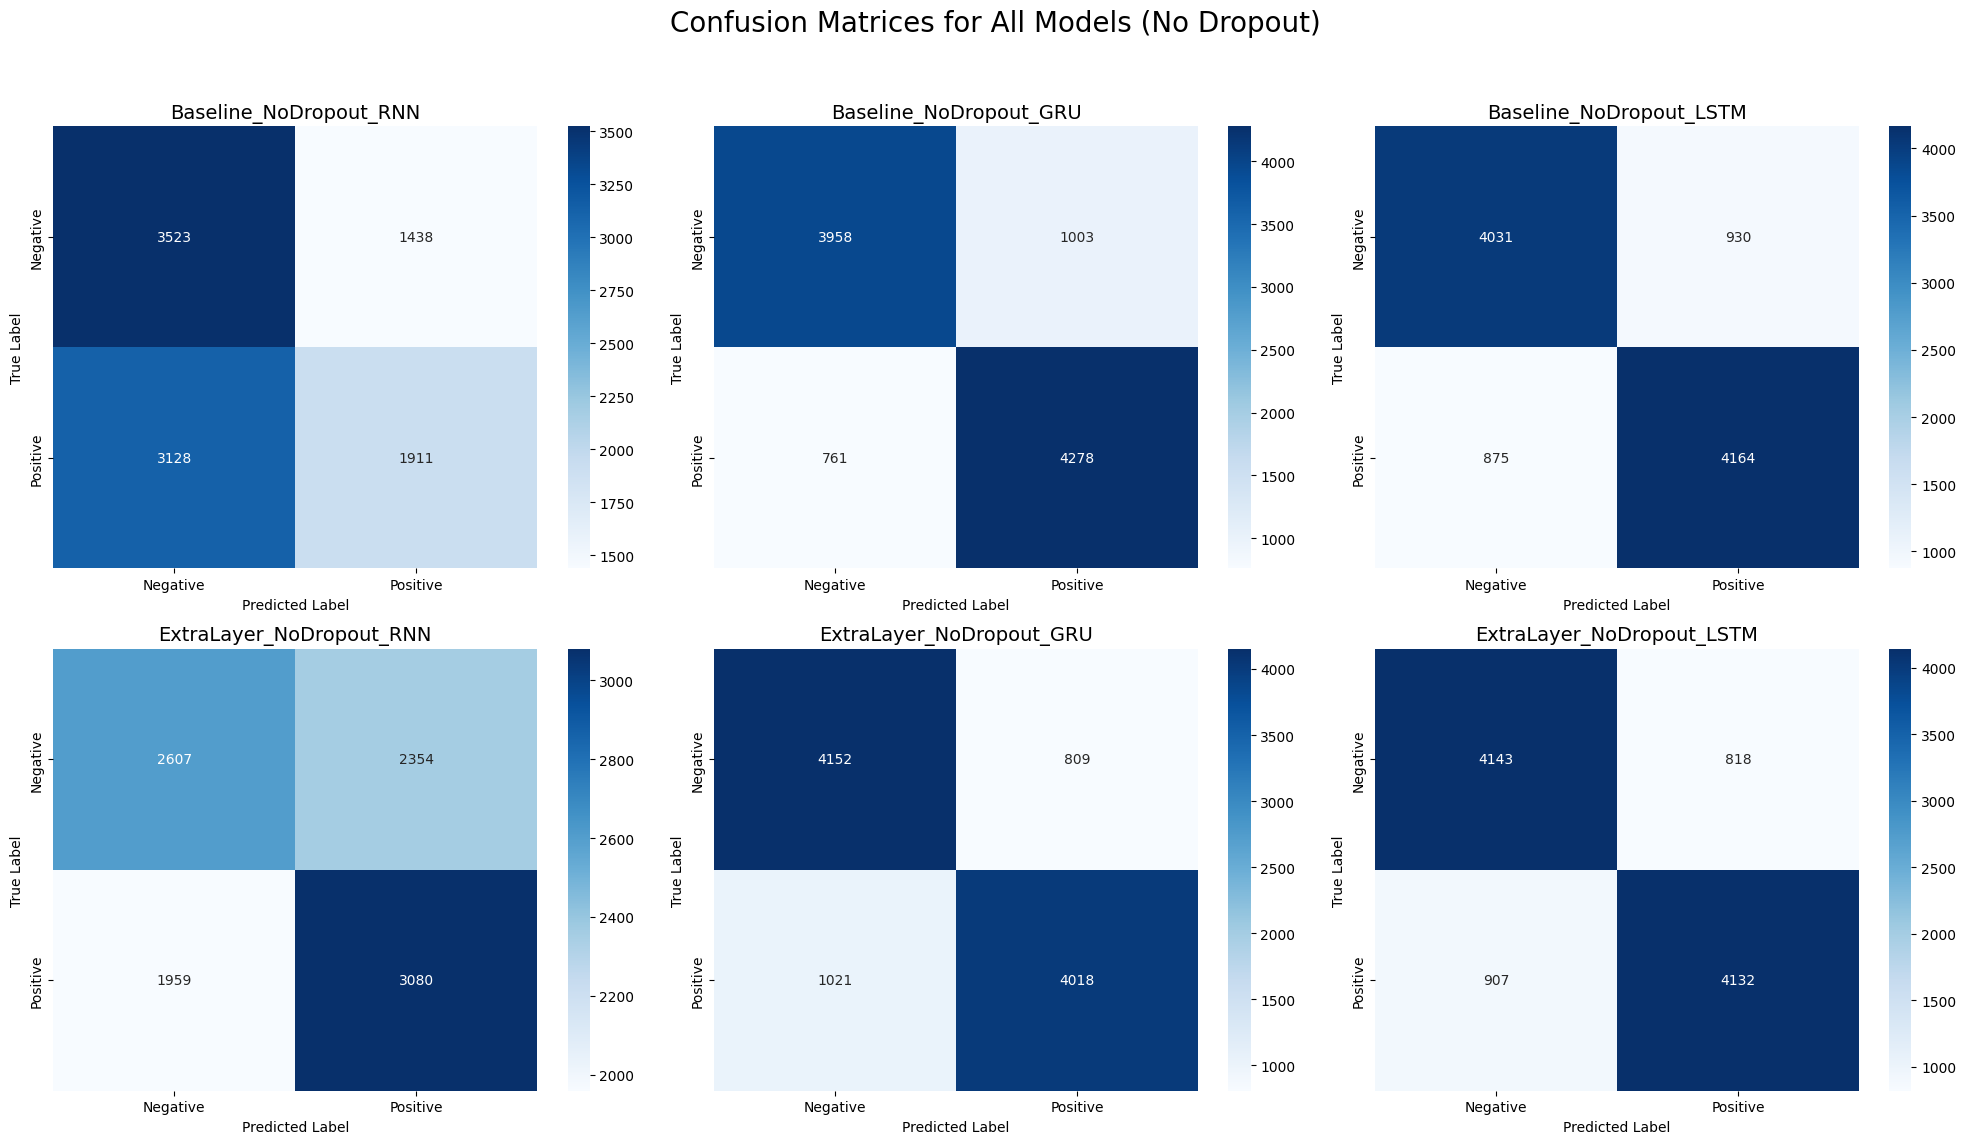


Cell 3 Complete: Analysis finished.


In [8]:
# --- 6. Final Comparative Plots (UPDATED FOR 6 MODELS) ---
print("\nGenerating final plots...")

# Check if variables exist before plotting
if 'full_history' not in locals():
    print("Error: 'full_history' not found. Please run Cell 2 to train models first.")
else:
    epochs_range = range(1, NUM_EPOCHS + 1)
    
    # --- PLOT 1: LOSS (Train & Test) ---
    plt.figure(figsize=(12, 8))
    for model_key, history in full_history.items():
        # Use different line styles for baseline vs extra layer
        linestyle = '--' if 'Baseline' in model_key else '-'
        plt.plot(epochs_range, history['train_loss'], label=f'{model_key} Train Loss', linestyle=linestyle)
        plt.plot(epochs_range, history['test_loss'], label=f'{model_key} Test Loss', linestyle=linestyle)

    plt.title('Model Comparison: Training & Test Loss (No Dropout)', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: ACCURACY (Train ONLY) ---
    plt.figure(figsize=(12, 8))
    for model_key, history in full_history.items():
        linestyle = '--' if 'Baseline' in model_key else '-'
        plt.plot(epochs_range, history['train_acc'], label=f'{model_key} Train Accuracy', linestyle=linestyle)

    plt.title('Model Comparison: Training Accuracy (No Dropout)', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 7. Confusion Matrices (UPDATED FOR 6 MODELS) ---
print("\nGenerating Confusion Matrices...")

if 'trained_models' not in locals():
    print("Error: 'trained_models' not found. Please run Cell 2 to train models first.")
else:
    # Create a 2x3 grid for the plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Confusion Matrices for All Models (No Dropout)', fontsize=20)
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    for i, (model_key, model) in enumerate(trained_models.items()):
        # Get predictions and true labels
        y_pred, y_true = get_predictions_and_labels(model, test_dataloader)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot heatmap on the appropriate subplot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Negative', 'Positive'], 
                    yticklabels=['Negative', 'Positive'],
                    ax=axes[i])
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_title(model_key, fontsize=14)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for main title
    plt.show()

print("\nCell 3 Complete: Analysis finished.")


--- Running Cell 5: Training Baseline (WITH Dropout) using HIGH Learning Rate (0.01) ---

--- Starting Baseline Study (WITH Dropout, HIGH LR) ---

--- Training Model: Baseline_HighLR_RNN ---
Epoch: 01 | Time: 0m 3s
	Train Loss: 0.714 | Train Acc: 50.20%
	Test. Loss: 0.696 | Test. Acc: 49.86%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.713 | Train Acc: 50.30%
	Test. Loss: 0.755 | Test. Acc: 49.48%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.712 | Train Acc: 50.21%
	Test. Loss: 0.696 | Test. Acc: 49.89%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.715 | Train Acc: 50.18%
	Test. Loss: 0.704 | Test. Acc: 49.52%
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.715 | Train Acc: 50.03%
	Test. Loss: 0.751 | Test. Acc: 50.49%
Epoch: 06 | Time: 0m 2s
	Train Loss: 0.717 | Train Acc: 49.55%
	Test. Loss: 0.696 | Test. Acc: 49.86%
Epoch: 07 | Time: 0m 2s
	Train Loss: 0.712 | Train Acc: 50.18%
	Test. Loss: 0.696 | Test. Acc: 50.22%
Epoch: 08 | Time: 0m 2s
	Train Loss: 0.711 | Train Acc: 50.22%
	Test. Loss: 0.709 | Test. Acc:

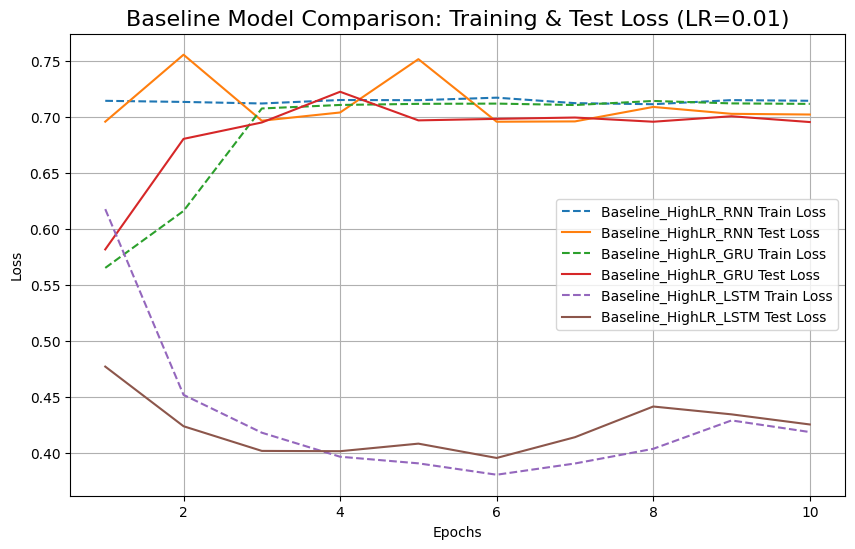

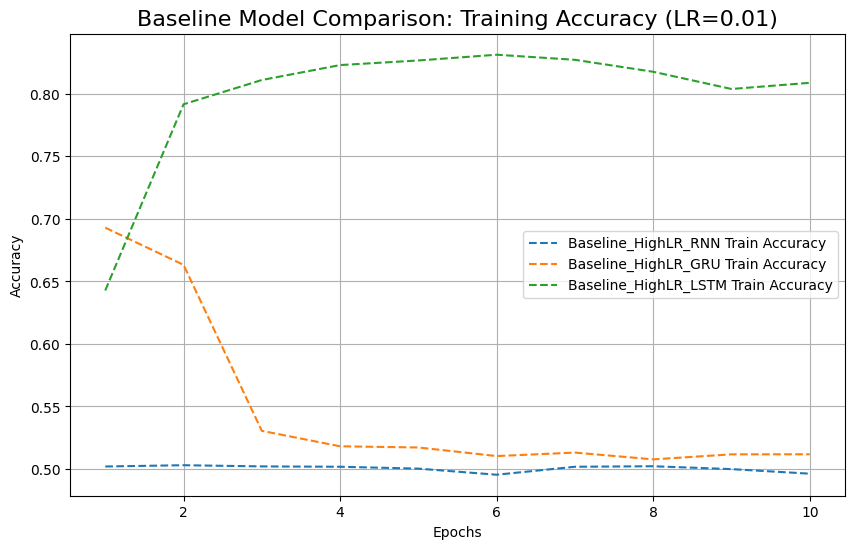


Generating Confusion Matrices...


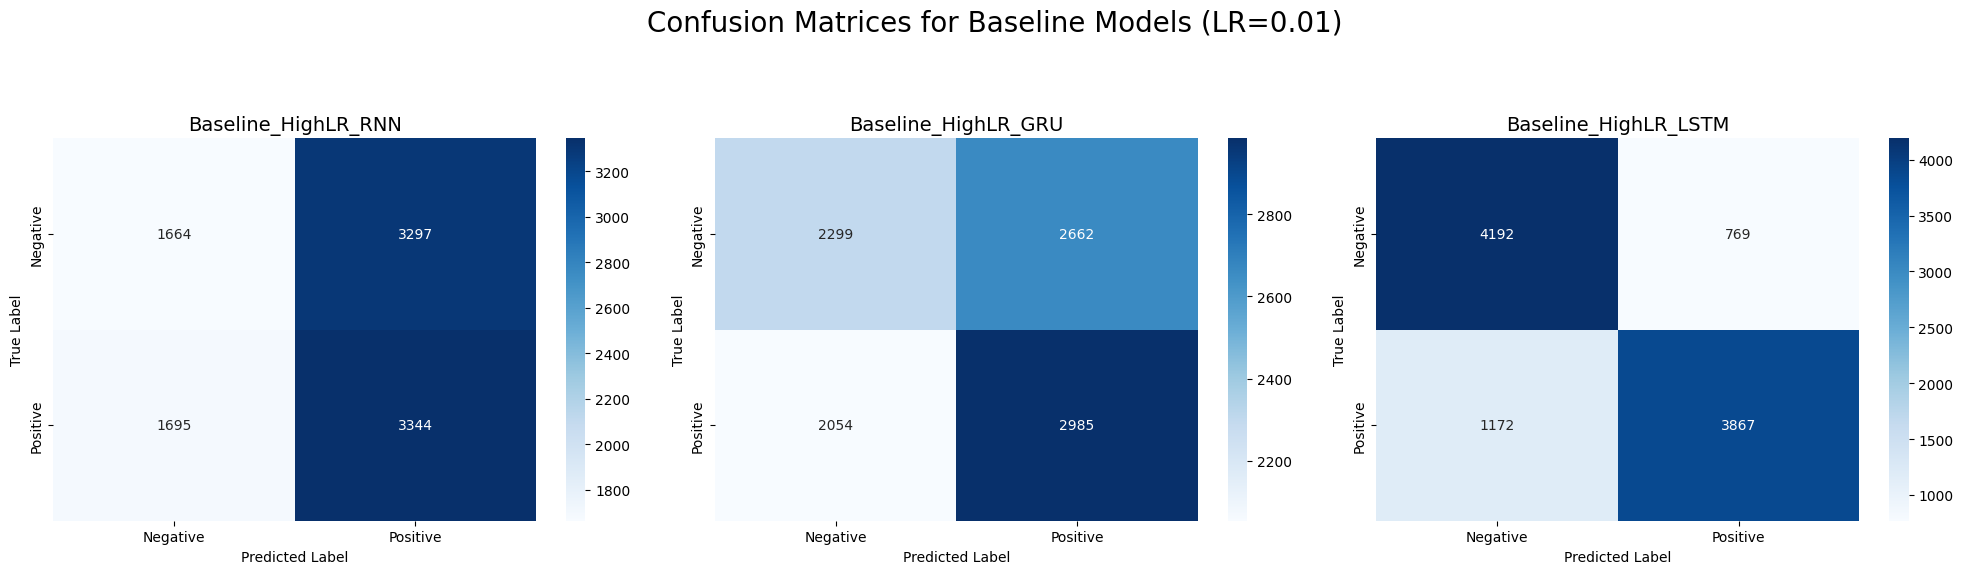


Cell 5 Complete: Analysis finished.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from functools import partial

# --- NEW: Set a higher learning rate for this experiment ---
NEW_LEARNING_RATE = 0.01

print(f"\n--- Running Cell 5: Training Baseline (WITH Dropout) using HIGH Learning Rate ({NEW_LEARNING_RATE}) ---")

# --- 3. Model Definition (Baseline WITH Dropout) ---
# Re-defining the class here in case the kernel was restarted
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx, model_type='LSTM', n_layers=2, dropout=0.3):
        super().__init__()
        self.model_type = model_type
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        
        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=n_layers, 
                              batch_first=True, dropout=dropout)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers,
                              batch_first=True, dropout=dropout)
        else: # Default to LSTM
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                               batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        
        if self.model_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
            
        hidden = self.dropout(hidden[-1, :, :])
        prediction = self.fc(hidden)
        return prediction

# --- 5. Main Study Execution (Baseline WITH Dropout, HIGH LR) ---
rnn_types_to_study = ['RNN', 'GRU', 'LSTM']

# Store results in new variables
results_high_lr = {}
full_history_high_lr = {} 
trained_models_high_lr = {} 

print("\n--- Starting Baseline Study (WITH Dropout, HIGH LR) ---")

# Check if data loaders exist
if 'train_dataloader' not in locals() or 'test_dataloader' not in locals():
    print("Error: DataLoaders not found. Please run Cell 2 to load data first.")
else:
    # Loop over the 3 RNN types
    for rnn_type in rnn_types_to_study:
        
        model_key = f"Baseline_HighLR_{rnn_type}"
        print(f"\n--- Training Model: {model_key} ---")
        
        model = SentimentModel(
            vocab_size=len(vocab),
            embed_dim=EMBED_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=1,
            pad_idx=PAD_IDX,
            model_type=rnn_type,
            dropout=DROPOUT_RATE
        ).to(device)
        
        # --- CHANGED: Using the NEW_LEARNING_RATE ---
        optimizer = optim.Adam(model.parameters(), lr=NEW_LEARNING_RATE)
        criterion = nn.BCEWithLogitsLoss()
        
        best_test_acc = 0
        history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
        
        for epoch in range(NUM_EPOCHS):
            start_time = time.time()
            
            train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion)
            test_loss, test_acc = evaluate_epoch(model, test_dataloader, criterion)
            
            end_time = time.time()
            epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\tTest. Loss: {test_loss:.3f} | Test. Acc: {test_acc*100:.2f}%')
        
        results_high_lr[model_key] = best_test_acc * 100
        full_history_high_lr[model_key] = history
        trained_models_high_lr[model_key] = model

    # --- Final Results in one line ---
    print("\n--- Study Complete (HIGH LR) ---")
    print("Final Best Test Accuracies (over 10 epochs):")
    for model_key, acc in results_high_lr.items():
        print(f"\t{model_key}: {acc:.2f}%")
        
    # --- 6. Final Comparative Plots (Baseline WITH Dropout, HIGH LR) ---
    print("\nGenerating final plots...")

    epochs_range = range(1, NUM_EPOCHS + 1)
        
    # --- PLOT 1: LOSS (Train & Test) ---
    plt.figure(figsize=(10, 6))
    for model_key, history in full_history_high_lr.items():
        plt.plot(epochs_range, history['train_loss'], label=f'{model_key} Train Loss', linestyle='--')
        plt.plot(epochs_range, history['test_loss'], label=f'{model_key} Test Loss')

    plt.title(f'Baseline Model Comparison: Training & Test Loss (LR={NEW_LEARNING_RATE})', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- PLOT 2: ACCURACY (Train ONLY) ---
    plt.figure(figsize=(10, 6))
    for model_key, history in full_history_high_lr.items():
        plt.plot(epochs_range, history['train_acc'], label=f'{model_key} Train Accuracy', linestyle='--')

    plt.title(f'Baseline Model Comparison: Training Accuracy (LR={NEW_LEARNING_RATE})', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 7. Confusion Matrices (Baseline WITH Dropout, HIGH LR) ---
    print("\nGenerating Confusion Matrices...")

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Confusion Matrices for Baseline Models (LR={NEW_LEARNING_RATE})', fontsize=20)
    
    axes = axes.flatten()
    
    for i, (model_key, model) in enumerate(trained_models_high_lr.items()):
        y_pred, y_true = get_predictions_and_labels(model, test_dataloader)
        cm = confusion_matrix(y_true, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Negative', 'Positive'], 
                    yticklabels=['Negative', 'Positive'],
                    ax=axes[i])
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_title(model_key, fontsize=14)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()

print("\nCell 5 Complete: Analysis finished.")